<a href="https://colab.research.google.com/github/Boon-Yang/Machine-Learning-for-Defect-Detection-In-Additive-Manufacturing/blob/master/Training%26Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Notebook to G. Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install ipympl

In [ ]:
import scipy.io as io
import os 
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import h5py
import seaborn as sns
!ls

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow.keras.backend as K

from keras.layers import Input, Flatten, Reshape, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import SGD
from keras import backend as K

from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping
import os

from ipywidgets import interact
# import ipywidgets
from IPython.display import display
# from google.colab import widgets
import ipywidgets as widgets
import matplotlib.gridspec as gridspec

 buil2_model_clean.h5   df_build3.csv	   ' Layer1v2.ipynb'
 build2_model.h5        encoder_build3.h5   PCA_Plot_build2.ipynb
 build3_model.h5        features_df2.csv    PCA_Plot.ipynb
 df_build2.csv	        label_Build2.csv


In [ ]:
os.chdir('/content/drive/My Drive/FYP MAT Data')

In [ ]:
matfiles = [dir for dir in os.listdir() if '.mat' in dir and '200' not in dir]
print()
matfiles

['build_ref_layer_101.mat',
 'build2_layer_110.mat',
 'build1_r2_layer_101.mat',
 'build3_layer _223.mat']

# Functions

In [ ]:
def min_max_norm(meltpool_img):
  return (meltpool_img - np.min(meltpool_img))/np.ptp(meltpool_img)

In [ ]:
def show_images(imageIDs, data):
  if len(imageIDs) <= 20:
    fig, axes = plt.subplots(figsize=(20, 15), nrows = 4, ncols = int(np.ceil((len(imageIDs)/4))))
  else:
    fig, axes = plt.subplots(figsize=(30, 25), nrows = int(np.ceil((len(imageIDs)/4))), ncols = 4)
  plt.tight_layout()
  axes = axes.flatten()
  
  list(map(lambda x: x.set_axis_off(), axes))

  for idx, imageID in enumerate(imageIDs):
    ax=axes[idx]
    imageArray = data[imageID]
    ax.imshow(imageArray, cmap='inferno')
    ax.set_title(imageID)
  return axes

In [ ]:
# mean abs error is used as metrics
def block_reconstruction_err(hatching_range, block_no, data, model):
  block_err=[]  
  for i in hatching_range[block_no]:
    trial = min_max_norm(data[i]).astype('float32')
    pred = model.predict(trial.reshape(1, 128, 128, 1)).reshape(128, 128)
    block_err.append(abs(trial - pred).mean())
  return block_err

# Autoencoder

In [ ]:
import keras.backend as K

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
input_img = Input(shape=(128, 128, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# flatten and compress
shape = K.int_shape(encoded) 
bn = Flatten()(encoded)
bn = Dense(20)(bn)
bnRec = Dense(shape[1] * shape[2] * shape[3], activation='relu')(bn)
encoded = Reshape((shape[1], shape[2], shape[3]))(bnRec)


x = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
autoencoder.compile(optimizer=sgd, loss='mse')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1310740   
_________________________________________________________________
dense_2 (Dense)              (None, 65536)             1376256   
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 64, 16)        0   

In [ ]:
os.chdir('/content/drive/My Drive/FYP MAT Data')
os.getcwd()

'/content/drive/My Drive/FYP MAT Data'

In [ ]:
import numpy as np
import h5py

f = h5py.File('build2_layer_110.mat','r')

########################
# Uncomment to load data
data = f.get('temperatureimgs')
data = np.array(data)
########################

In [ ]:
build_2_hatching_range = {1: range(0, 26000),
                    2: range(39790,66250),
                    3: range(79700,105600),
                    4: range(120450,146400),
                    5: range(160500,186400),
                    6: range(200000,226000),
                    7: range(241000,267000),
                    8: range(280800,306700),
                    9: range(320480,346600)
                    }

# mean abs error is used as metrics

In [ ]:
features_df2 = pd.read_csv('extracted_temperature_features_build2')

In [ ]:
features_df2.columns

Index(['blockNo', 'imageId', 'spatterArea', 'spatterDiameter',
       'spatterEccentricity', 'spatterNum', 'blobArea', 'blobDiameter',
       'blobEccentricity', 'blobNum', 'focus'],
      dtype='object')

In [ ]:
features_df2['isFocused'] = features_df2['blockNo'].apply(lambda x: 1 if (x == 3 or x == 2) else 0 )
features_df2.groupby('blockNo')[['focus', 'isFocused']].first()

,focus,isFocused
blockNo,,
1,16,0
2,4,1
3,8,1
4,-8,0
5,12,0
6,0,0
7,-12,0
8,-4,0
9,-16,0


In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [ ]:
def getBlockMetrics(features_df, block_no):
  tem = features_df[features_df['blockNo'] == block_no].copy()
  return tem

In [ ]:
block2Metrics = getBlockMetrics(features_df2, 2)
block3Metrics = getBlockMetrics(features_df2, 3)
block5Metrics = getBlockMetrics(features_df2, 5)
block6Metrics = getBlockMetrics(features_df2, 6)

training_df = pd.concat([block2Metrics, block3Metrics, block5Metrics, block6Metrics])
training_df = training_df.reset_index(drop=True)

In [ ]:
training_df.groupby('blockNo')['isFocused'].first()

blockNo
2    1
3    1
5    0
6    0
Name: isFocused, dtype: int64

In [ ]:
np.random.seed(42)

In [ ]:
X = training_df.drop(columns=['blockNo', 'imageId', 'isFocused', 'focus'])

# since kmeans operates based on the Euclidean distances, we need to standardize the dataset
Scaler = StandardScaler()
Scaler.fit(X)
X_scaled = Scaler.transform(X)

In [ ]:

optimal_k = 15
# Fit the standardized X, X_scaled with kmeans
kmeanModel = MiniBatchKMeans(n_clusters=optimal_k,  random_state = 2)
cluster_pred = kmeanModel.fit_predict(X_scaled)

# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X['cluster'] = cluster_pred


# X['cluster'].isna().sum()
X['cluster'].unique()

# uncomment to dump kmeans model
filename = 'KMeans_model.sav'
# pickle.dump(kmeanModel, open(filename, 'wb'))
X['isFocused'] = training_df['isFocused'].values

grpby_clusters = X.groupby(['cluster'])['isFocused'].value_counts()
focus_categories = training_df['isFocused'].values

outFocused_clusters = grpby_clusters[:, 0]/focus_categories[focus_categories==0].shape[0]
Focused_clusters = grpby_clusters[:, 1]/focus_categories[focus_categories==1].shape[0]

Focused_clusters.rename('Focused_Clusters', inplace=True)
outFocused_clusters.rename('outFocused_Clusters', inplace=True)
focused_data = pd.concat([Focused_clusters, outFocused_clusters], axis=1)
focused_data['cluster'] = focused_data.index

# null entries mean 0 proportion
focused_data.fillna(0, inplace=True)

# X['cluster']
training_df['cluster']=X['cluster']
training_df

,blockNo,imageId,spatterArea,spatterDiameter,spatterEccentricity,spatterNum,blobArea,blobDiameter,blobEccentricity,blobNum,focus,isFocused,cluster
0,2,39790,0,0.000000,0.000000,0,0,0.0,0.0,0,4,1,3
1,2,39791,0,0.000000,0.000000,0,0,0.0,0.0,0,4,1,3
2,2,39792,0,0.000000,0.000000,0,0,0.0,0.0,0,4,1,3
3,2,39793,0,0.000000,0.000000,0,0,0.0,0.0,0,4,1,3
4,2,39794,0,0.000000,0.000000,0,0,0.0,0.0,0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104255,6,225995,25,5.442106,0.464255,4,0,0.0,0.0,0,0,0,3
104256,6,225996,24,5.415428,0.457879,4,0,0.0,0.0,0,0,0,3
104257,6,225997,28,5.999978,0.545030,3,0,0.0,0.0,0,0,0,3
104258,6,225998,33,6.449698,0.568110,3,0,0.0,0.0,0,0,0,3


In [ ]:
# Restructure data to plot bar char
clusters_bar_data = pd.melt(focused_data, id_vars=['cluster'])
# clusters_bar_data

In [ ]:
clusters_bar_data.rename(columns={'variable':'Legend'}, inplace=True)
clusters_bar_data['Legend'] = clusters_bar_data['Legend'].replace({'Focused_Clusters': 'Focused',
                                     'outFocused_Clusters': 'Out-of-focus'})

In [ ]:
clusters_bar_data.rename(columns={'Legend':'Dataset'}, inplace=True)
clusters_bar_data.rename(columns={'value':'Proportion'}, inplace=True)
clusters_bar_data.rename(columns={'cluster':'Cluster Number'}, inplace=True)

(0.0, 0.5)

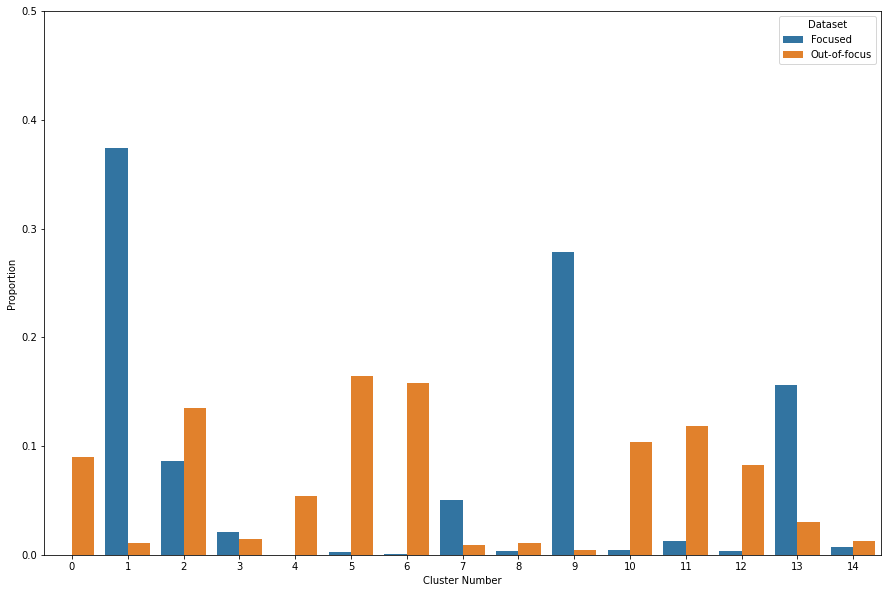

In [ ]:
# plt.rcParams.update({'font.size':30} )
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x='Cluster Number', y='Proportion', hue='Dataset', data=clusters_bar_data)
plt.ylim(ymin=0, ymax=0.5)

In [ ]:
# get training data from the focused clusters
training_data = data[training_df.imageId.values[(np.logical_or(training_df['cluster']==1, training_df['cluster']==9))]]

In [ ]:
# for img in training_data
norm_training_data = []
for i in range(int(training_data.shape[0]/2)):
  img = training_data[i]
  img = min_max_norm(img)
  norm_training_data.append(img)
norm_training_data = np.array(norm_training_data)

In [ ]:
# for img in training_data
norm_testing_data = []
for i in range(int(training_data.shape[0]/2), len(training_data)):
  img = training_data[i]
  img = min_max_norm(img)
  norm_testing_data.append(img)
norm_testing_data = np.array(norm_testing_data)

In [ ]:
import keras.backend as K

In [ ]:
np.random.seed(42)
# set_random_seed(42)
input_img = Input(shape=(128, 128, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# flatten and compress
shape = K.int_shape(encoded) 
bn = Flatten()(encoded)
bn = Dense(4)(bn)
bnRec = Dense(shape[1] * shape[2] * shape[3], activation='relu')(bn)
encoded = Reshape((shape[1], shape[2], shape[3]))(bnRec)


x = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)


encoder = Model(input_img, bn)
autoencoder = Model(input_img, decoded)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
autoencoder.compile(optimizer=sgd, loss='mse')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 8)         2056      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 4)         292       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 4)         0   

In [ ]:

history128v2 = autoencoder.fit(norm_training_data.reshape(-1, 128, 128, 1),
                norm_training_data.reshape(-1, 128, 128, 1),
                epochs=20,
                batch_size=32, 
                shuffle = True)

Epoch 1/20
17493/17493 [==============================] - 27s 2ms/step - loss: 0.0046
Epoch 2/20
17493/17493 [==============================] - 21s 1ms/step - loss: 0.0030
Epoch 3/20
17493/17493 [==============================] - 20s 1ms/step - loss: 0.0022
Epoch 4/20
17493/17493 [==============================] - 21s 1ms/step - loss: 0.0020
Epoch 5/20
17493/17493 [==============================] - 20s 1ms/step - loss: 0.0019
Epoch 6/20
17493/17493 [==============================] - 21s 1ms/step - loss: 0.0017
Epoch 7/20
17493/17493 [==============================] - 20s 1ms/step - loss: 0.0014
Epoch 8/20
17493/17493 [==============================] - 21s 1ms/step - loss: 0.0012
Epoch 9/20
17493/17493 [==============================] - 20s 1ms/step - loss: 0.0012
Epoch 10/20
17493/17493 [==============================] - 21s 1ms/step - loss: 0.0011
Epoch 11/20
17493/17493 [==============================] - 20s 1ms/step - loss: 0.0011
Epoch 12/20
17493/17493 [===========================

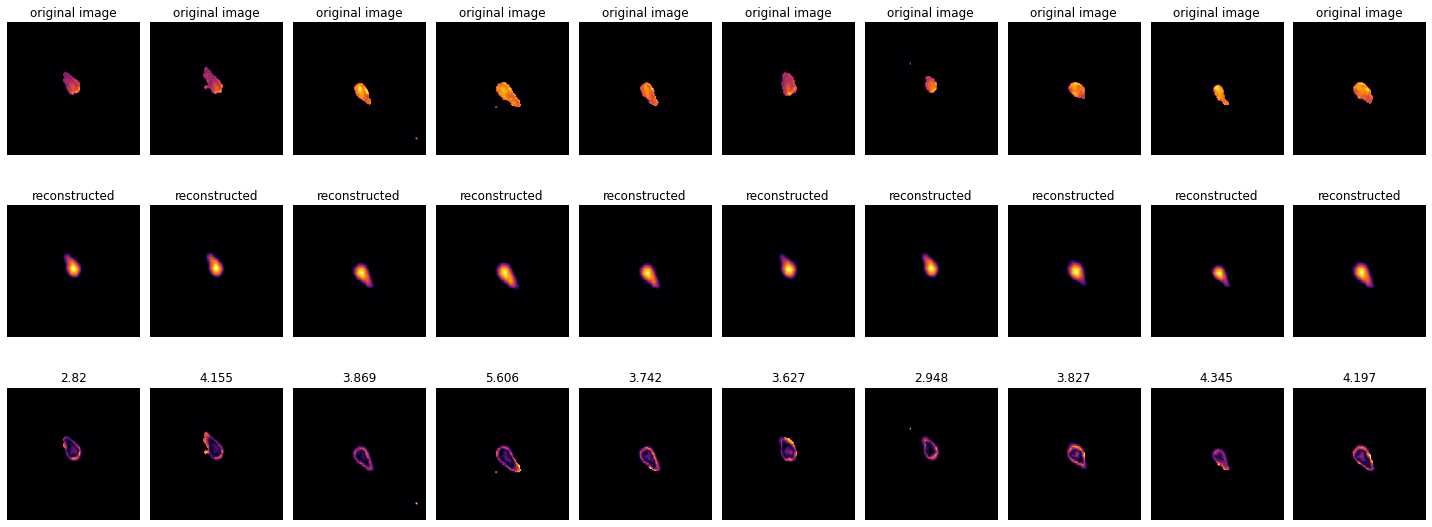

In [ ]:
fig, axes = plt.subplots(nrows = 3, ncols =10, figsize=(20, 8))

axes = axes.flatten()
list(map(lambda x: x.set_axis_off(), axes)) 

axes1 = axes[:10]
axes2 = axes[10:20]
axes3 = axes[20:]
# test_idx = [0, 1, 4, 30, 50, 55, 5110, 7555, 10020, 1016]
test_idx = [10, 20, 400, 300, 500, 550, 5010, 7855, 14020, 2016]
# test_idx = [160, 620, 4600, 6300, 5600, 5650, 5060, 7465, 16010, 206]

for count, idx in enumerate(test_idx):
  ax1 = axes1[count]
  ax2 = axes2[count]
  ax3 = axes3[count]

  test_img = norm_testing_data[idx]
  pred = autoencoder.predict(test_img.reshape(1, 128, 128, 1)).reshape(128, 128)
  error = abs(test_img-pred)

  ax1.imshow(test_img, cmap='inferno')
  ax1.set_title('original image')
  ax2.imshow(pred, cmap='inferno')
  ax2.set_title('reconstructed')
  ax3.imshow(error, cmap='inferno')
  ax3.set_title('{}'.format(round(error.mean()*1000, 3)))
plt.tight_layout()

In [ ]:
code = encoder.predict(norm_testing_data.reshape(-1, 128,128, 1))

Text(0, 0.5, 'Z2')

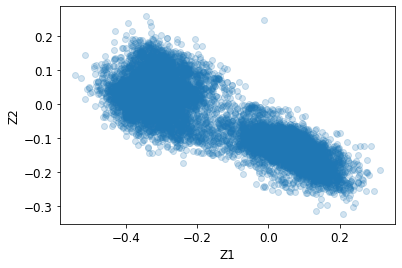

In [ ]:
plt.rcParams.update({'font.size':12})
plt.scatter(code[:,1], code[:, 2], alpha=0.2)
plt.xlabel('Z1')
plt.ylabel('Z2')

# plt.ylim(ymin=-1, ymax=1)
# plt.xlim(xmin=0, xmax=1.5)

In [ ]:
re = []
for test_img in norm_testing_data:
  pred = autoencoder.predict(test_img.reshape(1, 128, 128, 1)).reshape(128, 128)
  error = abs(test_img-pred)

  re.append(error.mean())
re = np.array(re)

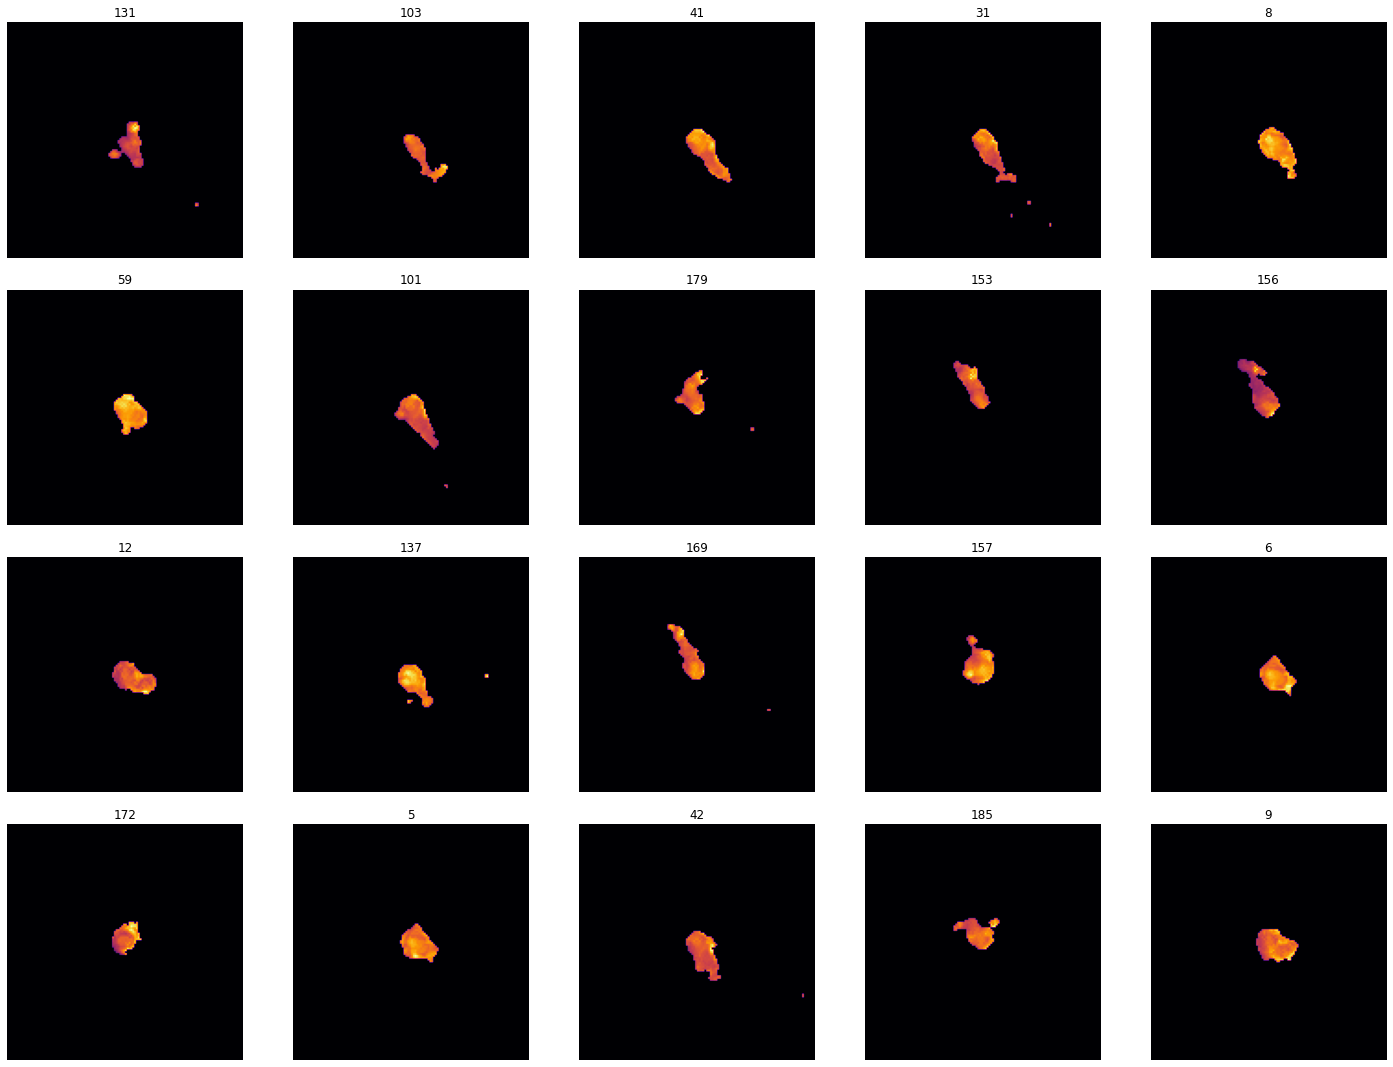

In [ ]:
display_data = norm_testing_data[np.logical_and(re>0.006, re<0.007)]
_ = show_images(np.random.randint(0, len(display_data), 20), display_data)

#Viz

In [ ]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

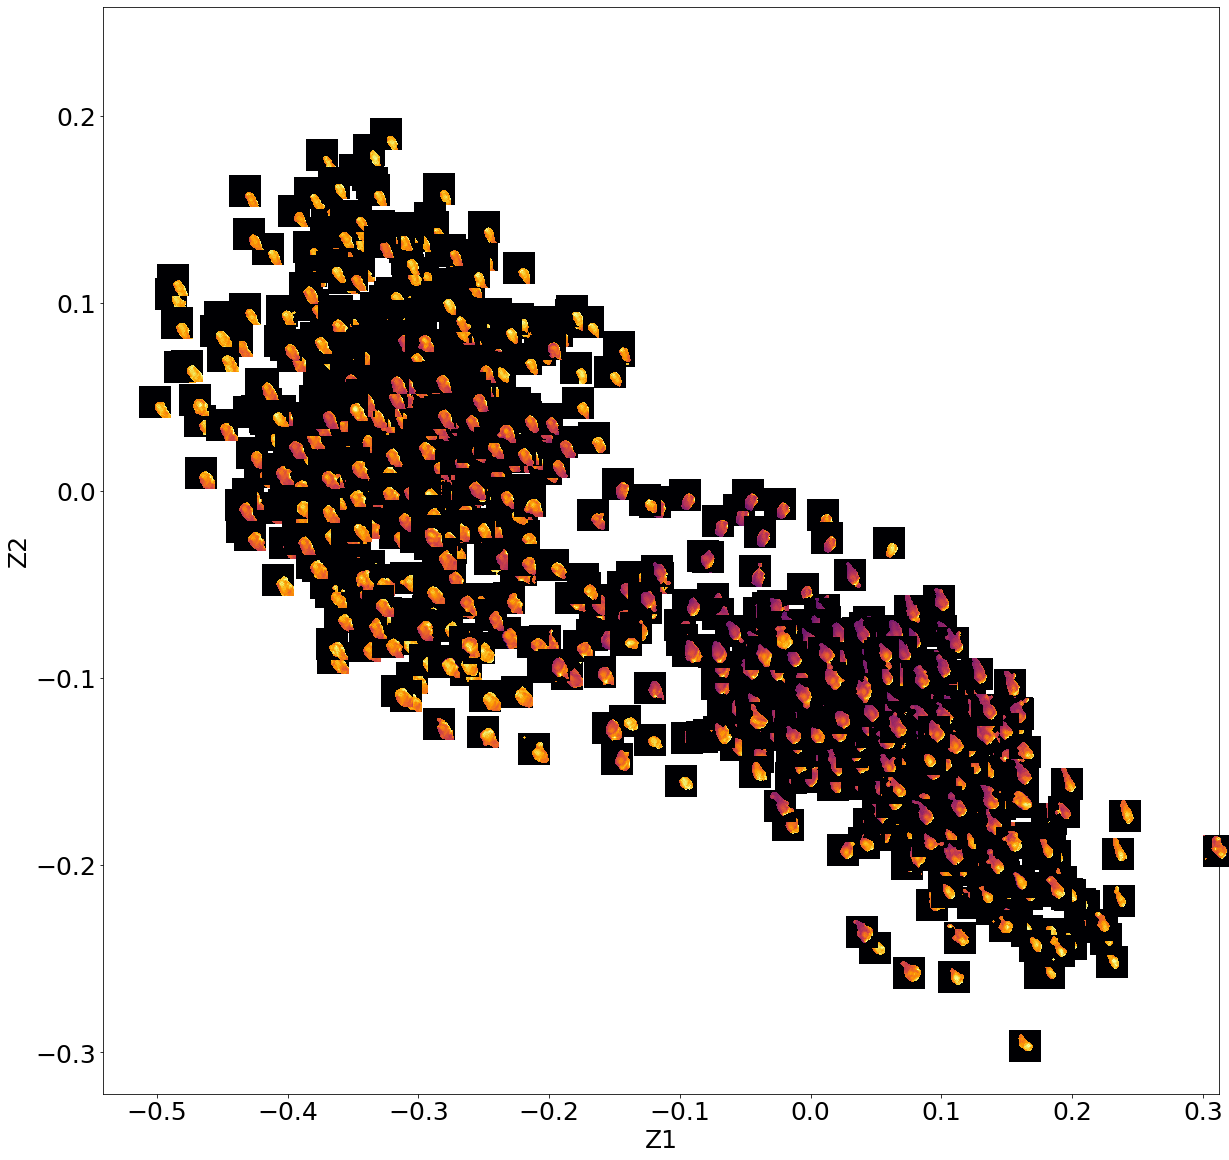

In [ ]:
plt.rcParams.update({'font.size':25})
pc1 = code[:,1]
pc2 = code[:, 2]


fig, ax = plt.subplots(figsize=(20, 20))
for ix in range(0, len(norm_testing_data), 10):
  img = norm_testing_data[ix]
  im = OffsetImage(img[44:76, 44:76], cmap='inferno')
  ab = AnnotationBbox(im, (pc1[ix], pc2[ix]), frameon=False)
  ax.add_artist(ab)
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.xlim(pc1.min(), pc1.max())
plt.ylim(pc2.min(), pc2.max())
plt.show()   



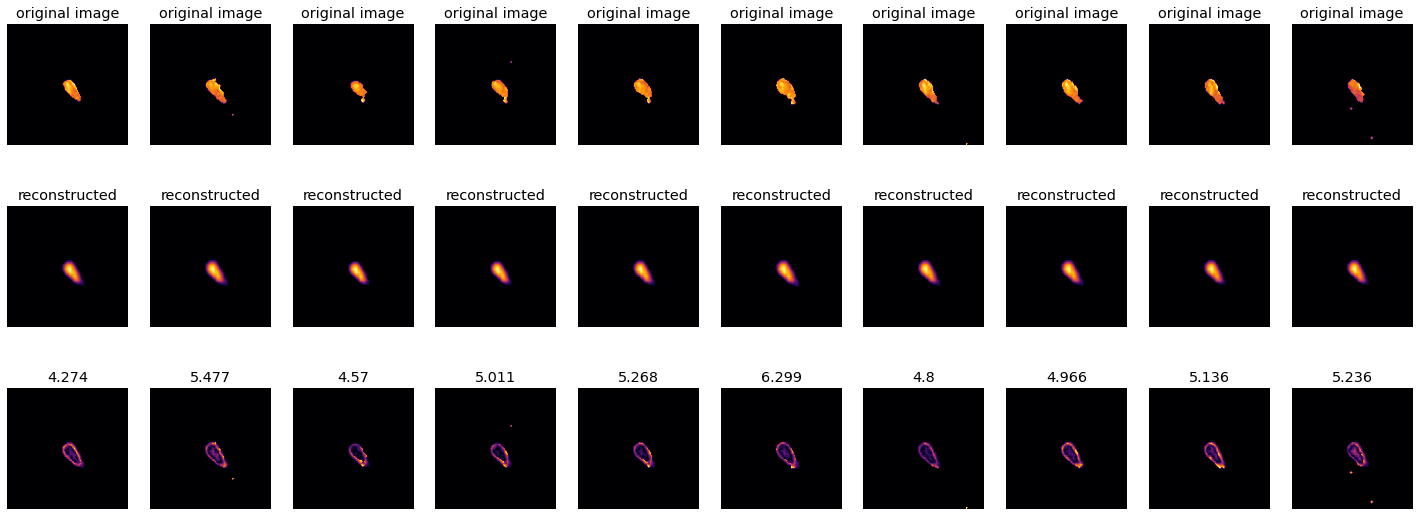

In [ ]:
test = norm_testing_data[abs(pc1)>0.45]
plt.rcParams.update({'font.size':12})
fig, axes = plt.subplots(nrows = 3, ncols =10, figsize=(20, 8))

axes = axes.flatten()
list(map(lambda x: x.set_axis_off(), axes)) 

axes1 = axes[:10]
axes2 = axes[10:20]
axes3 = axes[20:]
test_idx = np.random.randint(0, len(test), 10)

for count, idx in enumerate(test_idx):
  ax1 = axes1[count]
  ax2 = axes2[count]
  ax3 = axes3[count]

  test_img = test[count]
  pred = autoencoder.predict(test_img.reshape(1, 128, 128, 1)).reshape(128, 128)
  error = abs(test_img-pred)

  ax1.imshow(test_img, cmap='inferno')
  ax1.set_title('original image')
  ax2.imshow(pred, cmap='inferno')
  ax2.set_title('reconstructed')
  ax3.imshow(error, cmap='inferno')
  ax3.set_title('{}'.format(round(error.mean()*1000, 3)))
plt.tight_layout()

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
training_code = encoder.predict(norm_training_data.reshape(-1, 128,128, 1))

In [ ]:
training_re = []
for test_img in norm_training_data:
  pred = autoencoder.predict(test_img.reshape(1, 128, 128, 1)).reshape(128, 128)
  error = abs(test_img-pred)

  training_re.append(error.mean())
training_re = np.array(training_re)

Text(0, 0.5, 'Z2')

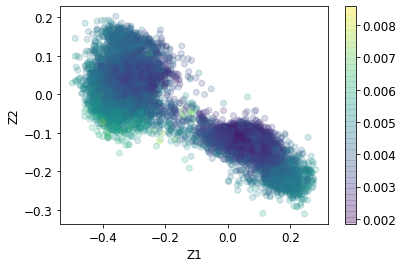

In [ ]:
# training data
plt.rcParams.update({'font.size':12})
plt.scatter(training_code[:,1], training_code[:, 2], alpha=0.2, c=training_re)
plt.colorbar()
plt.xlabel('Z1')
plt.ylabel('Z2')


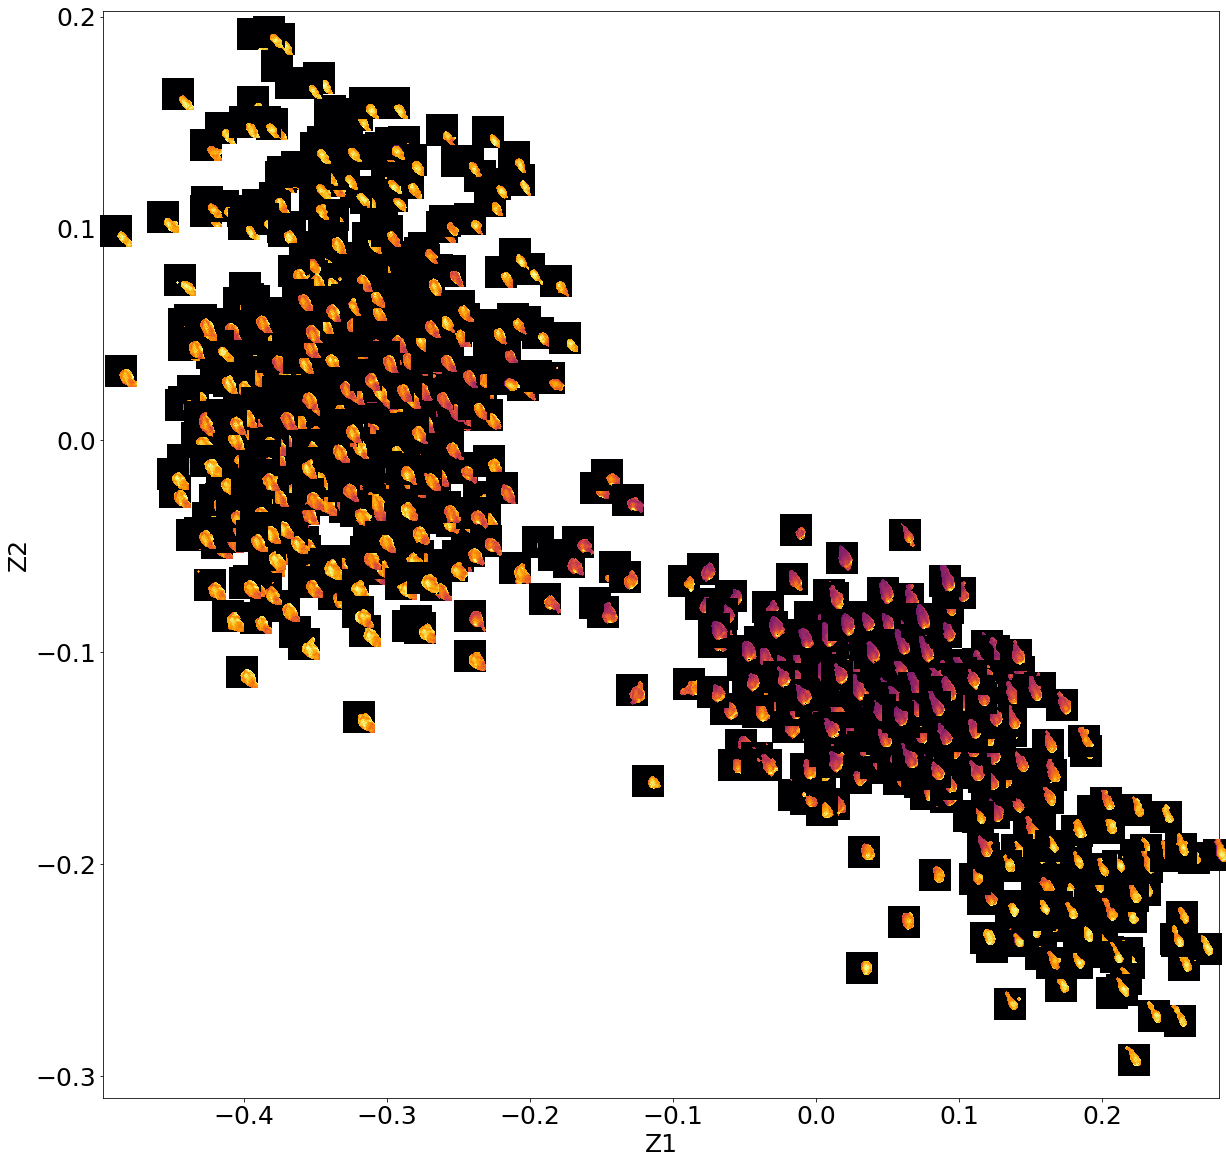

In [ ]:
plt.rcParams.update({'font.size':25})
pc1 = training_code[:,1]
pc2 = training_code[:, 2]


fig, ax = plt.subplots(figsize=(20, 20))
for ix in range(0, len(norm_training_data), 10):
  img = norm_training_data[ix]
  im = OffsetImage(img[44:76, 44:76], cmap='inferno')
  ab = AnnotationBbox(im, (pc1[ix], pc2[ix]), frameon=False)
  ax.add_artist(ab)
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.xlim(pc1.min(), pc1.max())
plt.ylim(pc2.min(), pc2.max())
plt.show()   

